In [15]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.mlab as mlab
import statistics as st
import ROOT

%matplotlib inline


In [13]:
def getValues(file):
    
    Time=np.array([])
    Amp=np.array([])

    with open(file,'r',newline='') as csvfile:
        for i in range(0,5 ):
            next(csvfile)
        read=csvfile.readlines()
    for i in read:
        value=i.split(",")
        Time=np.append(Time,float(value[0]))
        Amp=np.append(Amp,float(value[1].rstrip()))
        
    Values={"Amp":Amp,"Wb": Time}
    return Values

def _polynomial(x, *p):
    """Polynomial fitting function of arbitrary degree."""
    poly = 0.
    for i, n in enumerate(p):
        poly += n * x**i
    return poly    
        
        
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))


## code is @ https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


#### Histogram and Fit
def Histogram(values,bins,title,legLabel,ylabel="# of Events",xlabel="Vs",fit=True):
    mean,sigma=weighted_avg_and_std(values["Wb"],values["Amp"])
    plt.figure(figsize=(10,6))
    plt.title(title)
    weights=values["Amp"]/max(values["Amp"])
    n, bins, patches =plt.hist(values["Wb"],bins=bins,weights=weights,edgecolor='black',label=legLabel)
    if(fit==True):
        xmin,xmax=plt.xlim()
        x=np.linspace(xmin,xmax,1000)
        fit=norm.pdf(x,mean,sigma)

        Xfactor=max(n)/max(fit)
        plt.plot(x,fit*Xfactor,linewidth=4,label="Fit")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    plt.legend()
    plt.show()
    return mean,sigma

ExpectedPhoton=lambda Wb,g,QE,R:(Wb/R)/(1.6e-19*g*QE)

def getTheNumberofPhotons(SigFile,DCOffsetFile=""):
    Signal=getValues(SigFile)
    Sig=Histogram(Signal,50,"Signal","Signal",fit=False)
    
    if (DCOffsetFile):
        DCoff=Histogram(getValues(DCOffsetFile),50,"DCOff","DCoff",fit=False)
        mean=Sig[0]-DCoff[0]
        sigma=np.sqrt(Sig[1]**2+DCoff[1]**2)
    else:
        mean=Sig[0]
        sigma=Sig[1]
    ### For Run1
    #### Data Sheet for R7378A
    #### https://www.hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R7378A_TPMH1288E.pdf
    PMT2gain=2565793.9770992  ### Electrons per SinglePE at 1200V
    QuantumEfficeny=0.1  ### From the data sheet
    ScopeResistance=50
    
    NumberofPhotons=ExpectedPhoton(-mean,PMT2gain,QuantumEfficeny,ScopeResistance)
    PhotonsError=ExpectedPhoton(sigma,PMT2gain,QuantumEfficeny,ScopeResistance)

    
    return NumberofPhotons,PhotonsError

def HistogramROOT(s):
    c1=ROOT.TCanvas("h","test",800,600)
    h1=ROOT.TH1D("test","Fitting",12,-3e-8,0)
    gfit=ROOT.TF1("gaussfit","gaus",-3e-8,0)
    for i in range(0,len(Signal["Amp"])):
        x=s["Wb"][i]
        weight=s["Amp"][i]
        h1.Fill(x,weight)

    h1.Draw("HIST")
    h1.Fit(gfit,"E")
    h1.Draw("same")
    c1.Draw()
    del c1
    del h1

    
def GetMeanError(Xmean,Xerror):
    mean=Xmean.sum()/len(Xmean)
    Top=Xerror**2
    error=np.sqrt(Top.sum())/len(Xerror)
    return mean,error

def PlotGaussian(mu,sigma):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    plt.show()



In [3]:
Signal="Run_1/F2Signal00000.csv"
DCOFF="Run_1/F3DCOff00000.csv"
#SS=getValues("/media/ilker/writable/Programs/F6SignalAmp-S1-00001.csv")
#S1Sig="/media/ilker/writable/Programs/S1/F2Signal00000.csv"
#S1DCoff="/media/ilker/writable/Programs/F3DCOFF-S1-00000.csv"



In [4]:
## S1 Region
#getTheNumberofPhotons(S1Sig,S1DCoff)

In [5]:

#getTheNumberofPhotons(Signal,DCOFF)

Getting the Number of Photons for Run_1


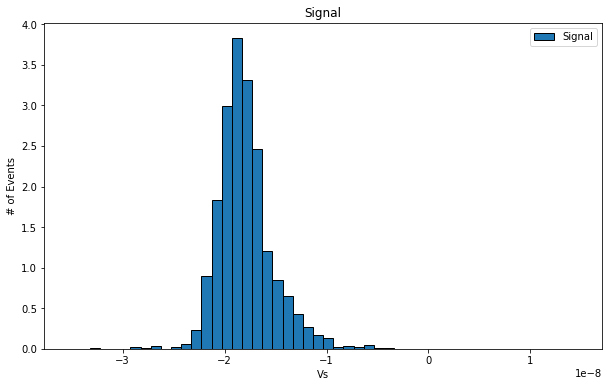

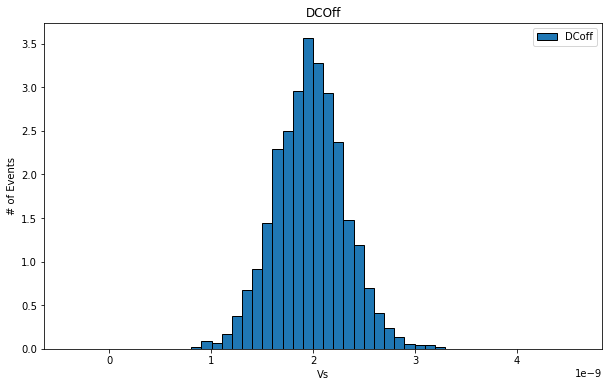

Photons = 9736.027538194287  and error = 1322.9104534802973
Getting the Number of Photons for Run_2


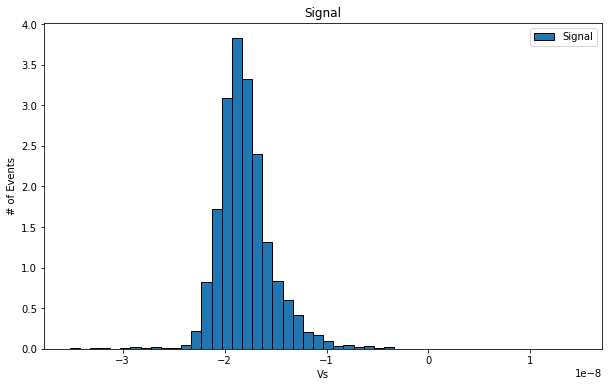

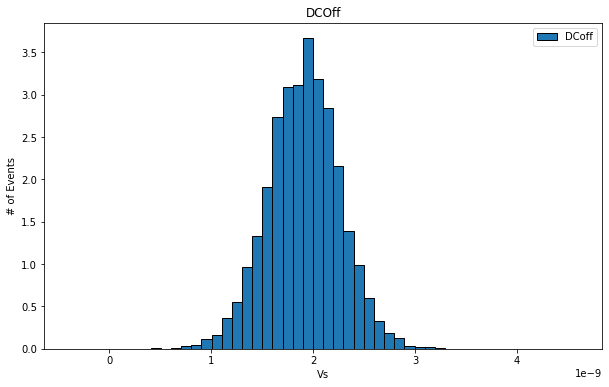

Photons = 9702.82143598489  and error = 1313.6390660677287
Getting the Number of Photons for Run_3


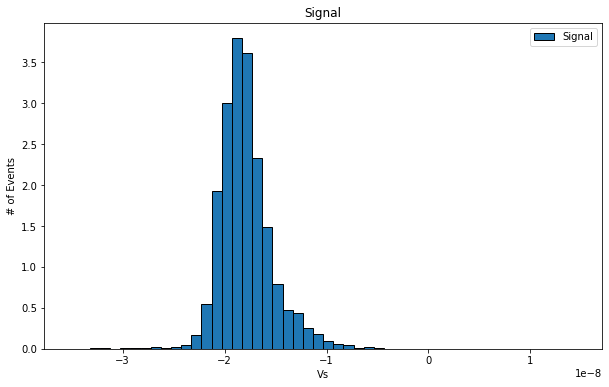

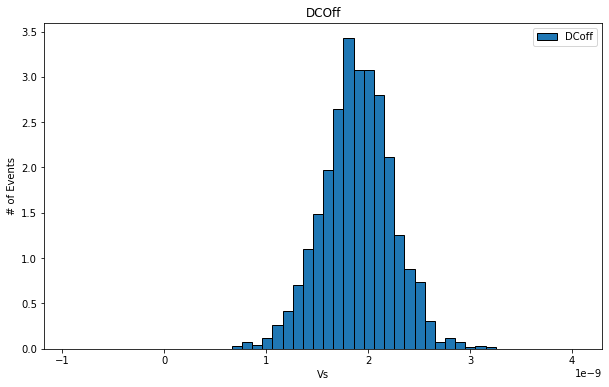

Photons = 9682.719303773725  and error = 1271.343989535683

------- Results For All Data Sets-----------

 Mean = 9707.189425984301  and Stdev = 1302.824521767385


In [6]:
#Path="/media/ilker/writable/Programs/"
## This is the Data I took
Path=""
Files=["Run_1","Run_2","Run_3"]
SigFileName="F2Signal00000.csv"
DcOffFileName="F3DCOFF-00000.csv"


Numph=np.array([])
Error=np.array([])

for i in Files:
    print(f"Getting the Number of Photons for {i}")
    Signall=Path+i+"/"+SigFileName
    DcOfff=Path+i+"/"+DcOffFileName
    
    ph=getTheNumberofPhotons(Signall,DcOfff)
    print(f"Photons = {ph[0]}  and error = {ph[1]}")
    Numph=np.append(Numph,ph[0])
    Error=np.append(Error,ph[1])

mean=st.mean(Numph)

result=GetMeanError(Numph,Error)

print(f"\n------- Results For All Data Sets-----------\n")
print(f" Mean = {result[0]}  and Stdev = {result[1]}")

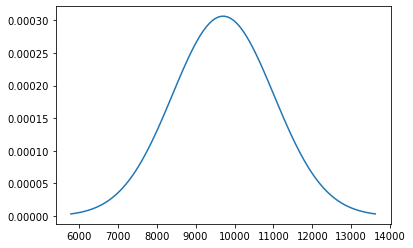

In [17]:

PlotGaussian(9707.189425984301,1302.824521767385)

Getting the Number of Photons for 1


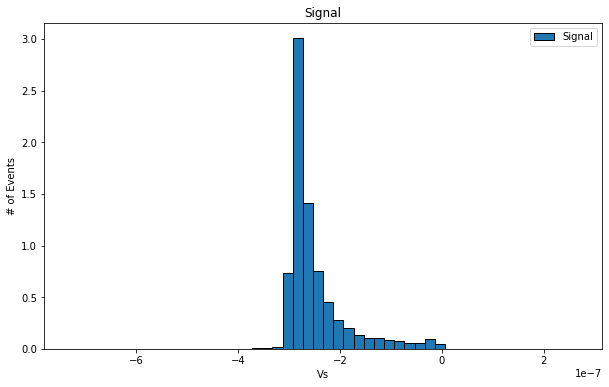

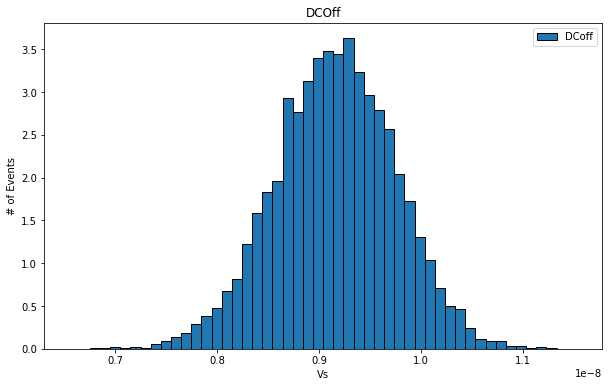

Photons = 125740.51333046996  and error = 29092.267933206895
Getting the Number of Photons for 2


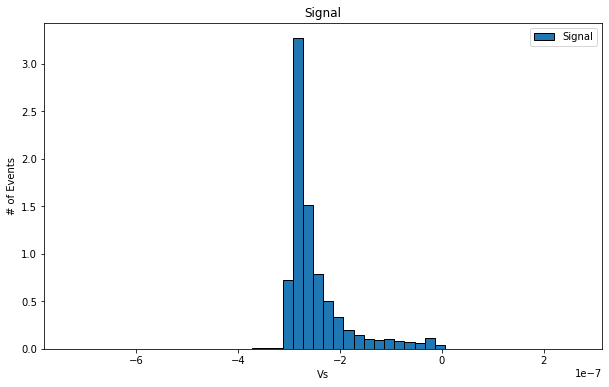

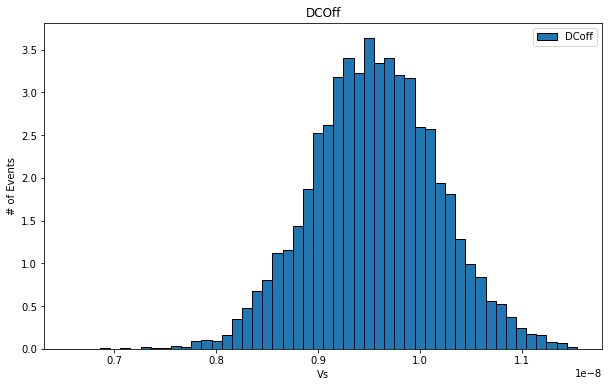

Photons = 125644.2106990508  and error = 29256.472891003166
Getting the Number of Photons for 3


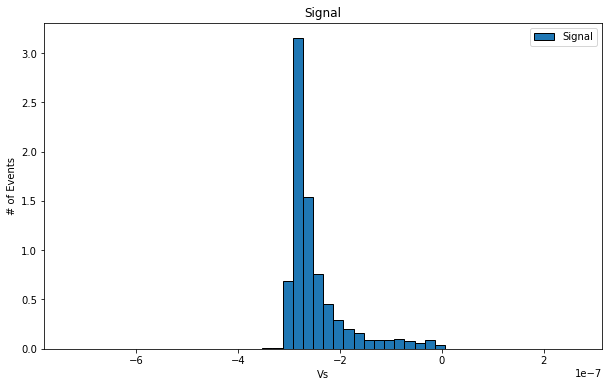

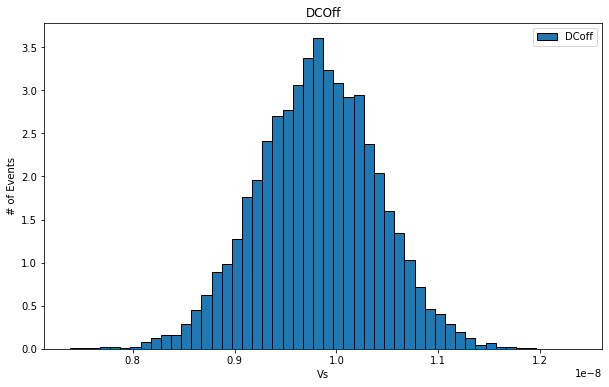

Photons = 125835.44437390949  and error = 29092.22845378024

------- Results For All Data Sets-----------

 Mean = 125740.05613447675  and Stdev = 29147.09257042311


In [8]:
## Nick's Data
Path="/media/ilker/writable/Programs/Pb210-06.03.22/"
Files=["1","2","3"]
SigFileName="F2Signal00000.csv"
DcOffFileName="F3DCOFF-00000.csv"

Numph=np.array([])
Error=np.array([])

for i in Files:
    print(f"Getting the Number of Photons for {i}")
    Signall=Path+i+"/"+SigFileName
    DcOfff=Path+i+"/"+DcOffFileName
    
    ph=getTheNumberofPhotons(Signall,DcOfff)
    print(f"Photons = {ph[0]}  and error = {ph[1]}")
    Numph=np.append(Numph,ph[0])
    Error=np.append(Error,ph[1])

mean=st.mean(Numph)

result=GetMeanError(Numph,Error)

print(f"\n------- Results For All Data Sets-----------\n")
print(f" Mean = {result[0]}  and Stdev = {result[1]}")

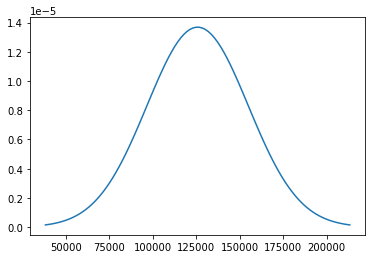

In [16]:
# Plot Gaussian
PlotGaussian(125740.05613447675,29147.09257042311)

In [ ]:

S1DCoff=getValues("/media/ilker/writable/Programs/Pb210-06.03.22/3/F3DCOff00000.csv")

dcoff=Histogram(S1DCoff,50,"DCoff","DCoff",fit=True)
